In [8]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")
include("src/utils/processing_tools.jl")

Main.ProcessingTools

# Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

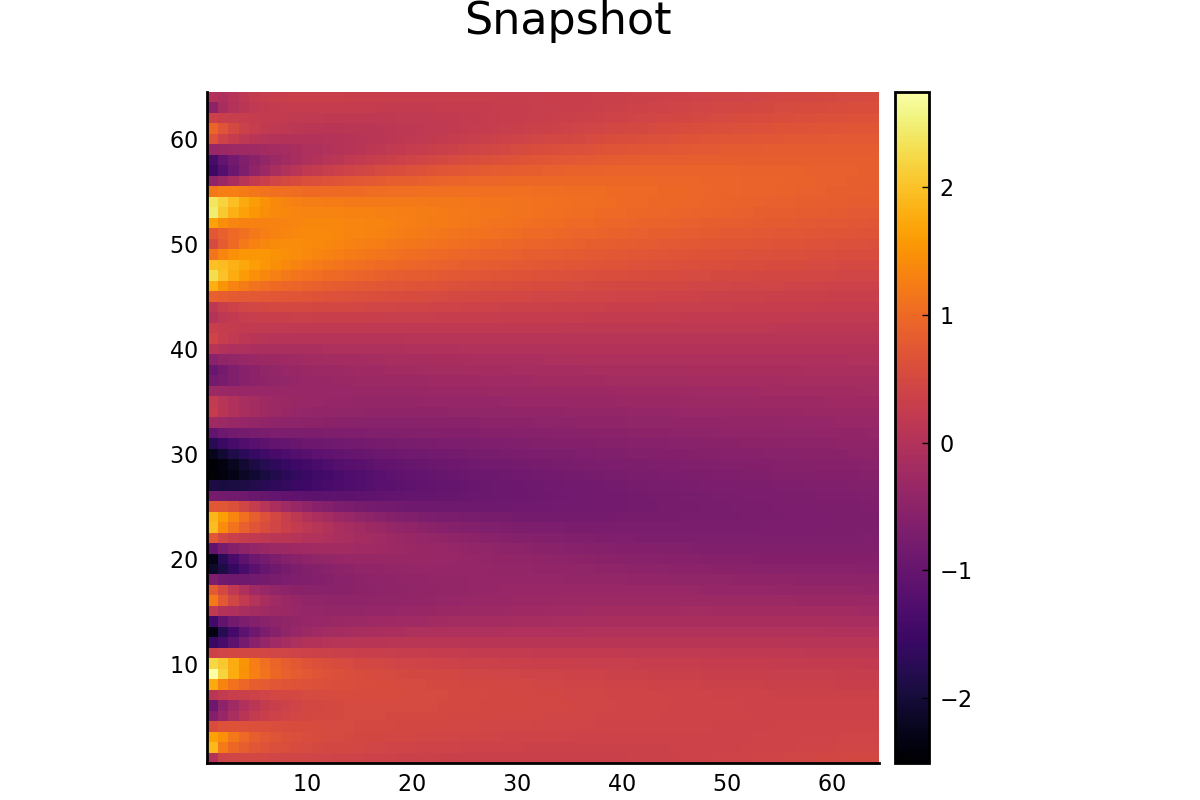

In [2]:
t_max = 0.5;
t_min = 0.;
x_max = pi;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.1;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);


u0 = InitialFunctions.high_dim_random_init(t, x, 20);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

In [ ]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
GraphicTools.show_state(u_a, "Snapshot generator")

In [ ]:
bas = POD.generate_pod_basis(u, true);
ϕ = bas.modes;
res = Equations.galerkin_projection(t, u, ϕ, nu, dx, dt);
GraphicTools.show_state(res, "")

In [ ]:
# dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 128, 2, 1, false, "./src/dataset/burgers_high_dim_training_set.jld2", "training_set");
# high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];
nu_dataset = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_nu_variational_dataset.jld2")["training_set"];

In [ ]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(nu_dataset)

--- 
# Training with NeuralODE object (DISCARDED)

In [ ]:
callback(theta, loss, u) = (display(loss); false)

In [ ]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

--- 
# Training with flux

In [3]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

In [9]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0., cuda=false)
   if cuda && CUDA.has_cuda()
      device = Flux.gpu
      CUDA.allowscalar(true) # false
      @info "Training on GPU"
  else
      device = Flux.cpu
      @info "Training on CPU"
  end

  model = model |> device
  opt = Flux.Optimiser(Flux.WeightDecay(reg), Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8))
  ltrain = 0.;
  lval = 0.;
  losses = [];

  @info("Loading dataset")
  (train_loader, val_loader) = ProcessingTools.get_data_loader(dataset, batch_size, ratio, false, false);

  @info("Building model")
  p, re = Flux.destructure(model);
  net(u, p, t) = re(p)(u);

  prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));

  function predict_neural_ode(x, t)
    tspan = (t[1], t[end]);
    _prob = remake(prob; u0=x, p=p, tspan=tspan);
    Array(solve(_prob, AutoTsit5(Rosenbrock23()), u0=x, p=p, saveat=t));
  end

  function loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = Reg.gaussian_augment(u_pred, noise);
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))) # + Reg.l2(p, reg);
    return l;
  end

  function traincb()
    ltrain = 0;
    for (x, y, t) in train_loader
      # (x, y, t) = (x, y, t) |> device;
      ltrain += loss(x, y, t);
    end
    ltrain /= (train_loader.nobs / train_loader.batchsize);
    @show(ltrain);
  end

  function val_loss(x, y, t)
    u_pred = predict_neural_ode(x, t[1]);
    ŷ = u_pred;
    l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
    return l;
  end

  function evalcb()
    lval = 0;
    for (x, y, t) in val_loader
      # (x, y, t) = (x, y, t) |> device;
      lval += val_loss(x, y, t);
    end
    lval /= (val_loader.nobs / val_loader.batchsize);
    @show(lval);
  end

  @info("Train")
  trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
  Flux.@epochs epochs begin
    Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    trigger() && break;
  end

  return re(p), p, ltrain, lval
end

training (generic function with 4 methods)

In [10]:
?ProcessingTools.get_data_loader

No documentation found.

`Main.ProcessingTools.get_data_loader` is a `Function`.

```
# 3 methods for generic function "get_data_loader":
[1] get_data_loader(dataset, batch_size, ratio) in Main.ProcessingTools at /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/utils/processing_tools.jl:57
[2] get_data_loader(dataset, batch_size, ratio, split_axis) in Main.ProcessingTools at /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/utils/processing_tools.jl:57
[3] get_data_loader(dataset, batch_size, ratio, split_axis, cuda) in Main.ProcessingTools at /Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/julia_src/neural_closure/src/utils/processing_tools.jl:57
```


In [11]:
function main()
  batch_size = 32;
  epochs = 10;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.FeedForwardNetwork(x_n, 2, 64);
  K, p = training(model, epochs, data, batch_size, 0.9, 0.01, 1.0e-6);
  return K, p
end

K, p = main()

┌ Info: Training on CPU
└ @ Main In[9]:8
┌ Info: Loading dataset
└ @ Main In[9]:17
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 13
└ @ MLUtils /Users/vdesgrange/.julia/packages/MLUtils/W3W0A/src/dataloader.jl:79
┌ Info: Building model
└ @ Main In[9]:20
┌ Info: Train
└ @ Main In[9]:66
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.6346778127868484
lval = 0.5459411083481823
ltrain = 0.5841586772881626
lval = 0.5095764633540706
ltrain = 0.5380387856586997
lval = 0.4788304949490749
ltrain = 0.5047763689462618
lval = 0.4530820064177577


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.47346736546913903
lval = 0.43169959659213303
ltrain = 0.4481145405538091
lval = 0.4131255532569785
ltrain = 0.43101224540103
lval = 0.3964345601326947
ltrain = 0.408059957871665
lval = 0.3808963111456499


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.38795324918072144
lval = 0.366829632854356
ltrain = 0.3782492090935775
lval = 0.35288558276642973
ltrain = 0.35531569055287077
lval = 0.3397478805110835
ltrain = 0.34444816171444814
lval = 0.3275195435394916


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3299393240499162
lval = 0.31618436377549786
ltrain = 0.3169412987043568
lval = 0.30538601655754466
ltrain = 0.29918764097370004
lval = 0.2950780254025246
ltrain = 0.28669140275228905
lval = 0.28507226117366125


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.27468538470967835
lval = 0.2754521485472092
ltrain = 0.2622122816588966
lval = 0.26655943173567775
ltrain = 0.25042553181112365
lval = 0.25802366298616025
ltrain = 0.24359332910366818
lval = 0.24989907604115685


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23291830991560575
lval = 0.24191643032954732
ltrain = 0.2268713171364717
lval = 0.2343845991605536
ltrain = 0.2135024938610769
lval = 0.22727361141999586
ltrain = 0.20585226833103487
lval = 0.22073288016415055


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19686311080595903
lval = 0.21434819591271065
ltrain = 0.19133566144069147
lval = 0.20841810705358377
ltrain = 0.18164859992664759
lval = 0.20270832471160272
ltrain = 0.177484712518505
lval = 0.19732066822674232


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1713165353642462
lval = 0.19227235612309884
ltrain = 0.1674274788012793
lval = 0.18742304963062376
ltrain = 0.16230913916917702
lval = 0.1827416403457357
ltrain = 0.15415542967611115
lval = 0.17824112894863456


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15132048114415933
lval = 0.17387539200443874
ltrain = 0.14309144219686307
lval = 0.16965564123797433
ltrain = 0.1394084535552742
lval = 0.16562260448379915
ltrain = 0.13599162142452353
lval = 0.16203308045718373


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13137615530350924
lval = 0.15856306685999735
ltrain = 0.12802034811512505
lval = 0.1553714579538451
ltrain = 0.12528716568800793
lval = 0.15226677691091495
ltrain = 0.1224584104978882
lval = 0.14922455367856238


(Chain(Dense(64 => 64, tanh), Dense(64 => 64, tanh), Dense(64 => 64)), Float32[-0.12559806, 0.161941, 0.1777157, 0.032505106, 0.14244424, 0.1052601, 0.13198034, 0.14159532, 0.17688759, 0.06867549  …  -0.017586464, 0.0067264284, 0.16668841, 0.1974945, 0.183801, 0.08971391, 0.13309881, 0.21969305, 0.21728295, -0.076824136])

In [ ]:
# @save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/tuning_burgers_basicautoencoder_20.bson" K p

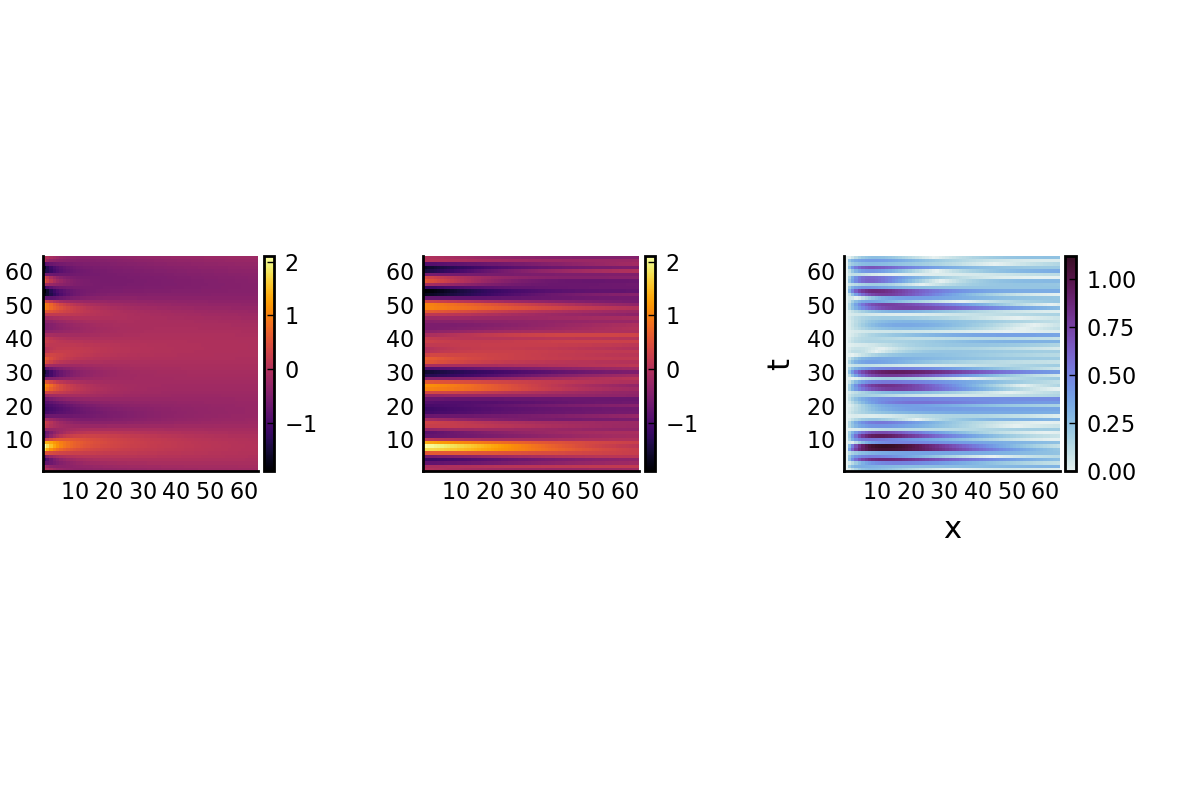

In [13]:
check_result(K, p, 2)

In [ ]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Rosenbrock23(), saveat=t);
i = 43
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)

### Hyper-parameters tuning

In [ ]:
using JLD2
using Hyperopt
a = JLD2.load("./src/examples/burgers/hyperopt_result.jld2");

In [ ]:
plot(a["ho"])